### Bi-Directional RNN for News Classification

Here we use Bi-Directional RNN to classify given news dataset into 4 classes:

○ World (0)
○ Sports (1)
○ Business (2)
○ Sci/Tech (3)

We cleaned the dataset first:

-> Converted the whole dataset to lower case.

-> Removed stop words.

-> Removed punctuation marks.

-> Replaced numbers and words containing numbers as a sunstring with "NUM" tokens.

We have used nn.Embedding layer here not to learn the embeddings, instead we have used word2vec word embeddings for the LSTM. Later we have initialized the nn.Embedding Layer with the word2vec learnt word embeddings.

To learn the best possible embedding for the words in the dataset, we have trained the word2vec model for 50 epochs.

We initialized word2vec model by the news sentences given in the dataset, and performed tokenization later using nltk to build the vocabulary.

We trained the RNN model for 20 epochs to learn the pattern to the best using AdamW optimizer using a LR of 0.0001 

The vanilla RNN Variant scores 82.8 % approx on Test Set while the Bi-Directional-RNN Variant scores 83.39 % approx on Test Set.

In [1]:
import nltk
import re
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


### Load the train data

In [3]:
train_set = pd.read_csv('./NLP3/train.csv')

In [4]:
train_set.head(10)

,index,text,label
0,0,Zimbabwe annual inflation drops to 209 percent...,0
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0
3,3,Security No. 1 for Afghan head President Hamid...,0
4,4,Palestinians say they hope Bush accepts dealin...,0
5,5,France Seeks Return of Reporters in Iraq Amid ...,0
6,6,Ads Make Closing Arguments in Campaign (AP) AP...,0
7,7,Mourning for submariner spans an ocean HALIFAX...,0
8,8,"Palestinian Girl Killed in Gaza Strip, Medics ...",0
9,9,US Marine killed in Iraq #39;s western Anbar p...,0


In [5]:
print(f'Train set contains total {len(train_set)} rows with {train_set.label.unique()} unique classes(labels)')

Train set contains total 2000 rows with [0 1 2 3] unique classes(labels)


In [6]:
y_train_raw = train_set['label']

In [7]:
# y_train_raw

### Pre-Processing

In [8]:
def remove_symbols(text):
    pattern = r'[^\w\s]'  
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [9]:
def remove_stopwords(text):
    
    stopwords_set = set(stopwords.words('english'))
    text = text.split()
    stopwords_removed_text = [word for word in text if word.lower() not in stopwords_set]
    
    return ' '.join(stopwords_removed_text)

In [10]:
train_set['text'] = train_set['text'].apply(lambda x: x.lower()) 
train_set['text'] = train_set['text'].apply(remove_symbols) 
train_set['text'] = train_set['text'].apply(remove_stopwords) 
train_set['text'] = train_set['text'].apply(lambda x: x.replace('\\', ' ')) 
train_set['text'] = train_set['text'].replace(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', 'NUM', regex=True)

In [11]:
train_set.head(5)

,index,text,label
0,0,zimbabwe annual inflation drops NUM percent re...,0
1,1,NUM dead haiti NUM mass grave haiti holds NUM ...,0
2,2,seven die japan NUM pact NUM japanese police f...,0
3,3,security NUM afghan head president hamid karza...,0
4,4,palestinians say hope bush accepts dealing ara...,0


### Load the Test Data

In [12]:
test_set = pd.read_csv('./NLP3/test.csv')

In [13]:
print(f'Test set contains total {len(test_set)} rows with {test_set.label.unique()} unique classes(labels)')

Test set contains total 500 rows with [0 1 2 3] unique classes(labels)


In [14]:
y_test_raw = test_set['label']

In [15]:
# y_test_raw

In [16]:
test_set['text'] = test_set['text'].apply(lambda x: x.lower()) 
test_set['text'] = test_set['text'].apply(remove_symbols) 
test_set['text'] = test_set['text'].apply(remove_stopwords) 
test_set['text'] = test_set['text'].apply(lambda x: x.replace('\\', ' ')) 
test_set['text'] = test_set['text'].replace(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', 'NUM', regex=True)

In [17]:
test_set.head()

,index,text,label
0,0,detainees seen minimal threat washington alleg...,0
1,1,japans army works plan cope north korean terro...,0
2,2,un council arrives nairobi un security council...,0
3,3,apec ministers urge new effort trade talks pac...,0
4,4,least five dead russia mine blast reuters reut...,0


### Vocabulary Creation

In [18]:
def tokenize_sentence(sentence):
    return word_tokenize(sentence)

In [19]:
sentences = train_set['text'].tolist() + test_set['text'].tolist()
len(sentences)

2500

In [20]:
tokenized_sentences = [tokenize_sentence(sentence) for sentence in sentences]
len(tokenized_sentences)

2500

##### Word2VEC

In [21]:
import gensim
from gensim.models import Word2Vec

In [22]:
word2vec_model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

In [23]:
%%time

word2vec_model.train(tokenized_sentences, total_examples=len(tokenized_sentences), epochs = 50)

CPU times: user 5.47 s, sys: 44.5 ms, total: 5.52 s
Wall time: 1.98 s


(3076549, 3252800)

In [24]:
# Vocabulary and word embeddings

vocabulary = word2vec_model.wv.index_to_key
word_embeddings = np.array([word2vec_model.wv[word] for word in vocabulary])

In [25]:
print(f'Size of the vocabulary we have: {len(vocabulary)}\nAnd Shape of the word embeddings is: {word_embeddings.shape}\
        \nSize of the each word vector is: {word_embeddings.shape[1]}'
     )

Size of the vocabulary we have: 13628
And Shape of the word embeddings is: (13628, 100)        
Size of the each word vector is: 100


###### Separating Train and Test Set

In [26]:
X_train_val = tokenized_sentences[:2000]
print(f'X_train_val is of length: {len(X_train_val)}')

X_train_val is of length: 2000


In [27]:
y_train_val = list(y_train_raw) 
y_train_val = torch.tensor(y_train_val)
print(f'y_train_val is of length: {len(y_train_val)}')

y_train_val is of length: 2000


In [28]:
X_test = tokenized_sentences[2000:]
y_test = y_test_raw

print(f'X_test is of length: {len(X_test)}\ny_test is of length: {len(y_test)}')

X_test is of length: 500
y_test is of length: 500


###### X will be converted later to numeric_indices by the word2vec.wv in the training loop

In [29]:
# Split data into train and test sets

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


In [30]:
print(f'Lengh of X_train is {len(X_train)}')
print(f'Lengh of y_train is {len(y_train)} \n')
print(f'Lengh of X_train is {len(X_val)}')
print(f'Lengh of y_test is {len(y_val)}')

Lengh of X_train is 1600
Lengh of y_train is 1600 

Lengh of X_train is 400
Lengh of y_test is 400


#### Dataset and Dataloader Creation

In [31]:
class NewsDataset(Dataset):
    
    def __init__(self, data, labels, vocab):
        self.data = data
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        news = self.data[idx]
        tokens = [self.vocab.index(word) for word in news]
        return torch.tensor(tokens), torch.tensor(self.labels[idx])


In [32]:
def pad_sequences(batch):
    
    batch_size = len(batch)
    max_len = max([len(seq) for seq, _ in batch])
    padded_seqs = torch.zeros(batch_size, max_len, dtype=torch.long)
    labels = torch.zeros(batch_size, dtype=torch.long)
    for i, (seq, label) in enumerate(batch):
        padded_seqs[i, :len(seq)] = seq
        labels[i] = label
    return padded_seqs, labels

In [33]:
train_dataset = NewsDataset(X_train, y_train, vocabulary)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True, collate_fn = pad_sequences)

In [34]:
val_dataset = NewsDataset(X_val, y_val, vocabulary)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle=True, collate_fn = pad_sequences)

In [35]:
test_dataset = NewsDataset(X_test, y_test, vocabulary)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True, collate_fn = pad_sequences)

In [36]:
def accuracy_fn(y_true, y_pred):
    
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = ( correct/len(y_pred) ) * 100
    
    return accuracy

#### Define the Architecture

Obsv: Average pooling increasing the accuracy from 45% to 81 % almost double. Sowe are using average pooling here on the output of the RNN

In [37]:
# Define the vanilla RNN model with custom embedding layer

class vanillaBiRNN(nn.Module):
    
    def __init__(self, word_vector_size, hidden_size, output_size):
        super(vanillaBiRNN, self).__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze = True)
        self.rnn = nn.RNN(word_vector_size, hidden_size, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.Softmax(dim = 1)

    # There are 2*hidden_units in the linear layee bcz of the bidirectional nature of the RNN

    def forward(self, x):
        
        embedded = self.embedding_layer(x)
        output, _ = self.rnn(embedded)
        
        # Average pooling along the sequence dimension
        avg_pooled = torch.mean(output, dim=1)  # Compute mean across the sequence dimension (dimension 1)
        output = self.fc(avg_pooled)  
        
        softMaxedOutput = self.softmax(output)

        return output

In [38]:
# Total number of tokens we have
vocab_size = len(word2vec_model.wv)

# Size of the embedding vector that will be created by the embedding layer
word_vector_size = 100

# no. of nodes in the RNN Layer
hidden_size = 200

# Number of classes
output_size = 4  

# Number of epochs
num_epochs = 20

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [40]:
biRNN = vanillaBiRNN(word_vector_size, hidden_size, output_size).to(device)
biRNN

vanillaBiRNN(
  (embedding_layer): Embedding(13628, 100)
  (rnn): RNN(100, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [41]:
# Define loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(biRNN.parameters(), lr = 0.0001)

Adam, 0.02, 28.50, epochs = 60

Adam, 0.002, 35.50, epochs = 60

Adam, 0.005, 30.25, epochs = 60

Adam, 0.0005, 44.75, epochs = 60

AdamW, 0.0005, 45.00, epochs = 60

AdamW, 0.00005, 47.00, epochs = 60

AdamW, 0.00005, 44.75, epochs = 100

AdamW, 0.00005, 66.25, epochs = 25


##### Training Loop

In [42]:
performance_metrics = []
best_val_accuracy = 0

for epoch in tqdm(range(num_epochs)):
    
    biRNN.train()
    train_loss = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        X, y = X.to(device), y.to(device)
        
        y_pred = biRNN(X)
                
        # calculate batch accumulative loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    with torch.inference_mode():
        
        biRNN.eval()
        val_loss, val_accuracy = 0,0
        
        for X_val, y_val in val_loader:
            
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            y_val_pred = biRNN(X_val)
            
            loss = loss_fn(y_val_pred, y_val)
            val_loss += loss
            val_accuracy += accuracy_fn(y_val, y_val_pred.argmax(dim=1))
        
        # Calculate avg. loss & accuracy
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        
        print(f"Epoch:{epoch+1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")
        performance_metrics.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            torch.save(biRNN.state_dict(), './best_biRNN_model.pth')
            print('Model State Dict Saved\n')
            best_val_accuracy = val_accuracy

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1 | Train loss: 1.1267 | Val loss: 0.8088 | Val accuracy: 71.7500
Model State Dict Saved

Epoch:2 | Train loss: 0.6898 | Val loss: 0.6339 | Val accuracy: 79.0000
Model State Dict Saved

Epoch:3 | Train loss: 0.5999 | Val loss: 0.5879 | Val accuracy: 78.2500
Epoch:4 | Train loss: 0.5647 | Val loss: 0.6025 | Val accuracy: 79.0000
Epoch:5 | Train loss: 0.5391 | Val loss: 0.5838 | Val accuracy: 78.7500
Epoch:6 | Train loss: 0.5344 | Val loss: 0.5835 | Val accuracy: 80.5000
Model State Dict Saved

Epoch:7 | Train loss: 0.5186 | Val loss: 0.5240 | Val accuracy: 80.7500
Model State Dict Saved

Epoch:8 | Train loss: 0.5033 | Val loss: 0.5084 | Val accuracy: 82.5000
Model State Dict Saved

Epoch:9 | Train loss: 0.5004 | Val loss: 0.5305 | Val accuracy: 80.2500
Epoch:10 | Train loss: 0.5023 | Val loss: 0.5201 | Val accuracy: 81.5000
Epoch:11 | Train loss: 0.4907 | Val loss: 0.5100 | Val accuracy: 80.7500
Epoch:12 | Train loss: 0.4794 | Val loss: 0.5261 | Val accuracy: 81.0000
Epoch:13 | Tr

### Evaluation on Test Set

In [43]:
# Load the latest Best checkpoint saved above.
y_predicted_list, y_test_true = [],[]

biRNN.load_state_dict(torch.load('./best_biRNN_model.pth'))

with torch.inference_mode():
    biRNN.eval()
    test_loss, test_accuracy = 0,0

    for X_test, y_test in tqdm(test_loader):

        X_test, y_test = X_test.to(device), y_test.to(device)

        y_test_pred = biRNN(X_test)
        
        y_predicted_list.append(y_test_pred.argmax(dim = 1))
        y_test_true.append(y_test)

        loss = loss_fn(y_test_pred, y_test)
        test_loss += loss
        test_accuracy += accuracy_fn(y_test, y_test_pred.argmax(dim=1))

    # Calculate avg. loss & accuracy
    test_loss = test_loss/len(test_loader)
    test_accuracy = test_accuracy/len(test_loader)

    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.2f}")

  0%|          | 0/32 [00:00<?, ?it/s]

Test loss: 0.5295 | Test accuracy: 81.45


#### Test Accuracy of the Bi-LSTM

In [44]:
print(f'Test Accuracy for the Bi-RNN model is: {test_accuracy:.2f} %')

Test Accuracy for the Bi-RNN model is: 81.45 %


In [45]:
# Convert the list of tensors to a single list of elements

y_predicted_list = [item for tensor in y_predicted_list for item in tensor.tolist()]
y_test_true = [item for tensor in y_test_true for item in tensor.tolist()]

#### F-1 Score

In [46]:
f1 = f1_score(np.array(y_test_true), np.array(y_predicted_list), average='weighted')
print(f'F1 Score for the model is: {f1:.4f}')

F1 Score for the model is: 0.8154


#### Confusion Matrix

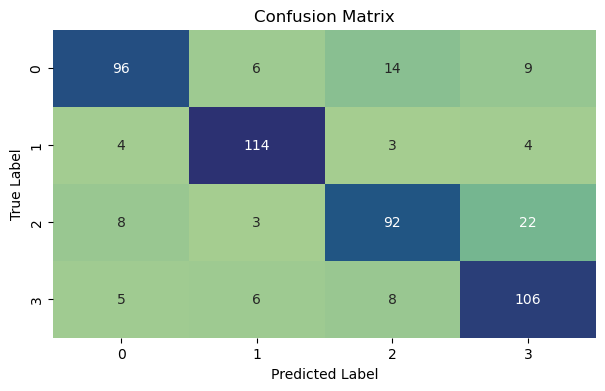

In [47]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_true, y_predicted_list)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()